## Installing necessary libraries and loading in libraries

In [ ]:
# Install necessary libraries
!pip install transformers datasets evaluate huggingface_hub scikit-learn matplotlib seaborn torch pandas

# Import necessary libraries
import torch
import numpy as np
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from huggingface_hub import notebook_login
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

## Logging into Hugging Face

In [ ]:
# Log in to Hugging Face Hub using notebook login
notebook_login()

## Loading in the pre-trained model & tokenizing the dataset

In [ ]:
# Load the emotion dataset from Hugging Face Datasets
emotions = load_dataset("emotion")

# Load the tokenizer for DistilBERT
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Tokenize the dataset
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# Store the tokenized dataset in emotions_encoded
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

# Split the dataset for validation
validation_dataset = emotions_encoded["validation"]

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=6)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Defining metrics, training arguments, training the model, and evaluating the model

In [ ]:
# Define the compute_metrics function to calculate accuracy and F1-score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

# Define the training arguments
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size

training_args = TrainingArguments(
    output_dir="./results",               # Output directory for saving model checkpoints
    num_train_epochs=5,                   # Changed from 2 to 5 epochs
    learning_rate=2e-5,                   # Learning rate 0.00002
    per_device_train_batch_size=batch_size, # Per-device batch size
    per_device_eval_batch_size=batch_size,  # Batch size for evaluation
    weight_decay=0.01,                    # L2 regularization
    evaluation_strategy="epoch",          # Evaluate at the end of each epoch
    logging_steps=logging_steps,          # Log at each logging step
    push_to_hub=True,                     # Push model to Hugging Face Hub after training
    hub_model_id="XtraPatrick987/emotions-classifier", # Username and model name
    disable_tqdm=False,                   # Enable progress bar for better visualization
    log_level="error",                    # Match the log level in chapter 2
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Fine-tune the model
trainer.train()

# Evaluate the model
eval_results = trainer.evaluate()
print(f"Evaluation Results: {eval_results}")

# Evaluation Results: {'eval_loss': 0.1407027542591095,
#                      'eval_accuracy': 0.939,
#                      'eval_f1': 0.9390331027524055,
#                      'eval_runtime': 4.0119,
#                      'eval_samples_per_second': 498.513,
#                      'eval_steps_per_second': 7.976,
#                      'epoch': 5.0}

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.795300,0.268458,0.916000,0.916046
2,0.202800,0.173734,0.931500,0.931409
3,0.135900,0.153720,0.936000,0.936568
4,0.107800,0.141501,0.938000,0.937976
5,0.088700,0.140703,0.939000,0.939033


Evaluation Results: {'eval_loss': 0.1407027542591095, 'eval_accuracy': 0.939, 'eval_f1': 0.9390331027524055, 'eval_runtime': 4.0119, 'eval_samples_per_second': 498.513, 'eval_steps_per_second': 7.976, 'epoch': 5.0}


## Pushing the model to Hugging Face

In [ ]:
# Save and push the fine-tuned model to Hugging Face Hub
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1725911125.9ba08447307c.494.1:   0%|          | 0.00/457 [00:00<?, ?B/s]

events.out.tfevents.1725910477.9ba08447307c.494.0:   0%|          | 0.00/8.32k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/XtraPatrick987/emotions-classifier/commit/b8315bb632df9921d47d0451ff14750b3c93c6da', commit_message='End of training', commit_description='', oid='b8315bb632df9921d47d0451ff14750b3c93c6da', pr_url=None, pr_revision=None, pr_num=None)

## Performing the error analysis and Confusion matrix

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

<ipython-input-6-f2ca0cdf6257>:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["label"]).to(model.device).long()


Top 10 Samples with the Highest Loss:
                                                   text     label  \
1950  i as representative of everything thats wrong ...  surprise   
1870  i guess i feel betrayed because i admired him ...       joy   
1111  im lazy my characters fall into categories of ...       joy   
1963  i called myself pro life and voted for perry w...       joy   
882   i feel badly about reneging on my commitment t...      love   
1683  i had applied for a job and they had assured m...     anger   
1840  id let you kill it now but as a matter of fact...       joy   
1836  i got a very nasty electrical shock when i was...      fear   
415   im kind of embarrassed about feeling that way ...      love   
259   when i noticed two spiders running on the floo...     anger   

     predicted_label      loss  
1950         sadness  7.451398  
1870         sadness  6.423133  
1111            fear  6.396485  
1963         sadness  6.285191  
882          sadness  5.873519  
1683

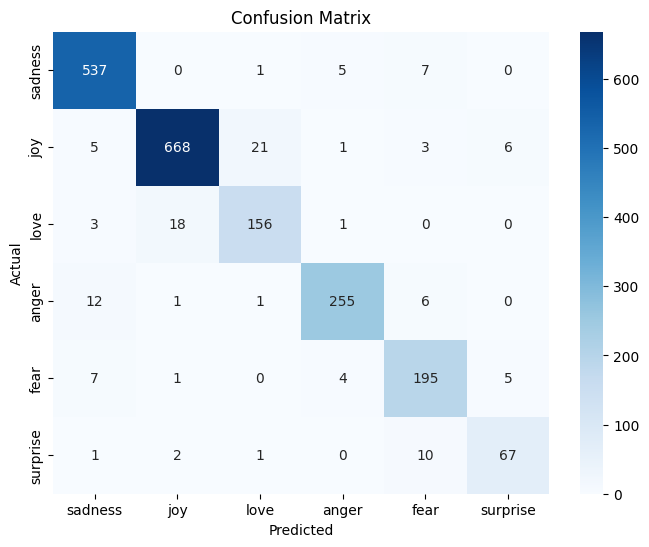

In [ ]:
from torch.nn.functional import cross_entropy

# Ensure dataset is in torch format
emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Define the forward pass with loss calculation
def forward_pass_with_label(batch):
    # Ensure all inputs are moved to the correct device (GPU/CPU), converting lists to tensors if necessary
    inputs = {k: torch.tensor(v).to(model.device) if isinstance(v, list) else v.to(model.device) for k, v in batch.items() if k in tokenizer.model_input_names}

    # Convert 'label' to a tensor and move it to the correct device
    labels = torch.tensor(batch["label"]).to(model.device).long()

    # No gradients during evaluation
    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, labels, reduction="none")

    # Return loss and predicted labels
    return {"loss": loss.cpu().numpy(), "predicted_label": pred_label.cpu().numpy()}

# Apply the forward pass to calculate loss for each sample in the validation set
validation_with_loss = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)

# Convert to pandas DataFrame for analysis
cols = ["text", "label", "predicted_label", "loss"]
df_test = pd.DataFrame({
    "text": emotions["validation"]["text"],
    "label": validation_with_loss["label"],
    "predicted_label": validation_with_loss["predicted_label"],
    "loss": validation_with_loss["loss"]
})

# Convert label integers back to strings for readability
label_names = emotions["validation"].features["label"].names
df_test["label"] = df_test["label"].apply(lambda x: label_names[x])
df_test["predicted_label"] = df_test["predicted_label"].apply(lambda x: label_names[x])

# Sort by loss (descending) to display the samples with the highest loss
df_test_sorted = df_test.sort_values(by="loss", ascending=False).head(10)
print("Top 10 Samples with the Highest Loss:")
print(df_test_sorted)

# Sort by loss (ascending) to display the samples with the lowest loss
df_test_sorted_lowest = df_test.sort_values(by="loss", ascending=True).head(10)
print("Top 10 Samples with the Lowest Loss:")
print(df_test_sorted_lowest)

# Display confusion matrix
y_preds = df_test["predicted_label"]
y_true = df_test["label"]
cm = confusion_matrix([label_names.index(y) for y in y_true], [label_names.index(y) for y in y_preds])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


## Printing out the full texts of the top 10 samples with highest loss

In [ ]:
# Sort the DataFrame by the 'loss' column in descending order to get the samples with the highest loss
df_test_sorted = df_test.sort_values(by="loss", ascending=False).head(10)

# Iterate over the sorted DataFrame and print the full text for each sample
for idx, row in df_test_sorted.iterrows():
    print(f"Text: {row['text']}\nLabel: {row['label']}\nPredicted Label: {row['predicted_label']}\nLoss: {row['loss']}\n")
    print("-" * 80)  # Separator for readability

# Based on the output, it seems that the model struggles the most when it recieves text that has contradictory or mixed emotions.
# Therefore, I will use contradictory and mixed emotions to trick the model.

Text: i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea
Label: surprise
Predicted Label: sadness
Loss: 7.4513983726501465

--------------------------------------------------------------------------------
Text: i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale
Label: joy
Predicted Label: sadness
Loss: 6.42313289642334

--------------------------------------------------------------------------------
Text: im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people
Label: joy
Predicted Label: fear
Loss: 6.396485328674316

--------------------------------------------------------------------------------
Text: i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed g

## Tricking the model into making a wrong prediction of a made up tweet

In [ ]:
# Creating an Obvious Misleading Tweet
fake_tweet = "I’m so excited that everything is falling apart, and I couldn’t be happier about how miserable it makes me feel."

# Tokenize and predict
device = "cuda" if torch.cuda.is_available() else "cpu"  # Automatically detect GPU if available, otherwise CPU
model.to(device)  # Move model to device

inputs = tokenizer(fake_tweet, return_tensors="pt").to(device)
outputs = model(**inputs)
predicted_label = outputs.logits.argmax(dim=-1)

# Convert predicted label to string
predicted_label_name = label_names[predicted_label.item()]

# Print the model's prediction for the fake tweet
print(f"Model prediction for the fake tweet '{fake_tweet}': {predicted_label_name}")

# The model predicted that the sentence is sadness when in reality is more "joyful". This shows that sentences which include sarcasm or
# irony is harder for the model to correctly predict.

Model prediction for the fake tweet 'I’m so excited that everything is falling apart, and I couldn’t be happier about how miserable it makes me feel.': sadness


## *How to load in a model from Hugging Face and make predictions (Extra)*

In [ ]:
# *Make sure to have the transformer library installed before running the code

# Load the model and tokenizer using the model ID (username/model_name)
# Its possible to load in both the tokenizer and the model from Hugging face.

from transformers import AutoModelForSequenceClassification, AutoTokenizer
# Specify the model name or path from Hugging Face
model_name = "XtraPatrick987/emotions-classifier"

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Load the model (for sequence classification)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Using the loaded model to make a prediction

# Example input text
sentence = "I HATE how the new Tesla model 3 looks!"

# Tokenize the input text
inputs = tokenizer(sentence, return_tensors="pt")

# Perform inference
outputs = model(**inputs)

# Get the predicted label
predicted_label = outputs.logits.argmax(dim=-1)
print(f"Predicted label: {predicted_label}")


Predicted label: tensor([3])
